In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from src.helper_functions import calc_NMI
warnings.simplefilter(action='ignore', category=FutureWarning)

In [196]:
def rename(df):
    df['modelname_old'] = df['modelname']
    df['modelname'] = df['modelname'].replace('euclidean', 'K-means: Least squares \n(sign-flipped eigenvectors)')
    df['modelname'] = df['modelname'].replace('diametrical', 'K-means: Diametrical')
    df['modelname'] = df['modelname'].replace('complex_diametrical', 'K-means: Complex diametrical')
    df['modelname'] = df['modelname'].replace('grassmann', 'K-means: Grassmann')
    df['modelname'] = df['modelname'].replace('weighted_grassmann', 'K-means: Weighted Grassmann')
    df['modelname'] = df['modelname'].replace('Watson', 'Mixture: Watson')
    df['modelname'] = df['modelname'].replace('Complex_Watson', 'Mixture: Complex Watson')
    df['modelname'] = df['modelname'].replace('ACG', 'Mixture: ACG')
    df['modelname'] = df['modelname'].replace('Complex_ACG', 'Mixture: Complex ACG')
    df['modelname'] = df['modelname'].replace('MACG', 'Mixture: MACG')
    df['modelname'] = df['modelname'].replace('SingularWishart', 'Mixture: Singular Wishart')
    df['modelname'] = df['modelname'].replace('Normal', 'Mixture: Gaussian')
    # if column LR doesnt exist, make it with zeros
    if 'LR' not in df.columns:
        df['LR'] = 0
    if 'HMM' not in df.columns:
        df['HMM'] = False

    names = [] #without the Kmeans or Mixture or HMM
    names2 = [] #with
    for i in range(len(df)):
        if 'Watson' in df['modelname'].iloc[i]:
            add_rank = ''
        else:
            add_rank = ' rank='+str(df['rank'].iloc[i])
        if df['HMM'].iloc[i]:
            add_HMM = 'HMM: '
        else:
            add_HMM = ''
        if 'Mixture' in df['modelname'].iloc[i]:
            names.append(df['modelname'].iloc[i][8:]+add_rank)
            if df['HMM'].iloc[i]:
                names2.append(add_HMM + df['modelname'].iloc[i][8:]+add_rank)
            else:
                names2.append(add_HMM + df['modelname'].iloc[i]+add_rank)
        else:
            names.append(df['modelname'].iloc[i][:8])
            names2.append(df['modelname'].iloc[i])
            
    df['names'] = names
    df['names2'] = names2
    return df

In [197]:
#model order loglik data
motorsocialinner = 0
pts_pr_subject_sum = np.array([279,279,279*2])
pts_pr_subject = [[284//2,274//2],[284//2,274//2],[284,274]]
num_subs = [155,155,100]
sets = ['train','test1','test2']
new_setnames = ['Train','Within-subject test','Out-of-sample test']
true_labels = [np.zeros((2,pts_pr_subject_sum[0])),np.zeros((2,pts_pr_subject_sum[1])),np.zeros((2,pts_pr_subject_sum[2]))]
for set in range(3):
    true_labels[set][0,:pts_pr_subject[set][0]] = 1
    true_labels[set][1,pts_pr_subject[set][0]:] = 1
df2MOTORSOCIAL = pd.DataFrame()
modelnames = ['Complex_Watson','Normal','MACG','SingularWishart','Watson','ACG','euclidean','diametrical','complex_diametrical','grassmann','weighted_grassmann','Complex_ACG']
for modelname in modelnames:
    for rank in [1,10,25]:
        if modelname in ['Complex_Watson','Watson','euclidean','diametrical','complex_diametrical','grassmann','weighted_grassmann'] and rank != 25:
            continue
        df = pd.read_csv('../data/results/116_results/MOTORSOCIALmodelorder_realdata_'+modelname+'_K=2_rank='+str(rank)+'.csv')
        best_inner = df['train_loglik'].idxmax()
        pss = []
        for s,setname in enumerate(sets):
            entries = []
            try:
                posteriors = np.loadtxt('../data/results/116_results/posteriors/MOTORSOCIALmodelorder_realdata_'+modelname+'_K=2_rank='+str(rank)+'_'+setname+'_posterior_inner'+str(best_inner)+'.txt')
            except:
                continue
            
            ps = []
            for i in range(num_subs[s]):
                p = posteriors[:,i*pts_pr_subject_sum[s]:(i+1)*pts_pr_subject_sum[s]]
                ps.append(p)
                nmi = calc_NMI(p,true_labels[s])
                entries.append([modelname,rank,new_setnames[s],nmi,i])
            pss.append(ps)

            df2MOTORSOCIAL = pd.concat([df2MOTORSOCIAL,pd.DataFrame(entries,columns=['modelname','rank','Set','NMI','Subject'])])
df = df2MOTORSOCIAL.copy()
df = rename(df)

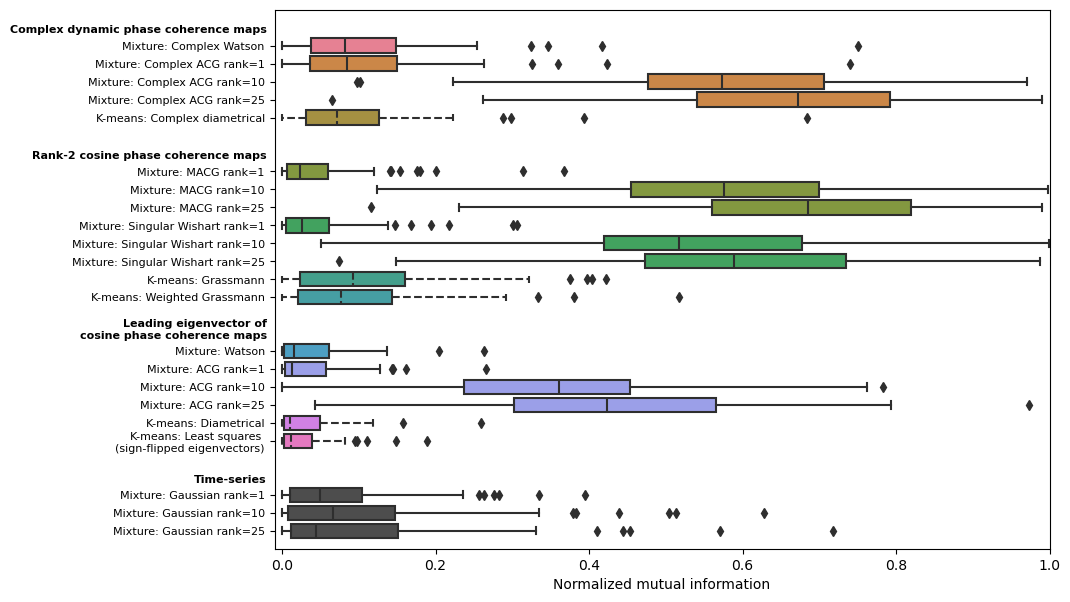

In [198]:
order = ['Mixture: Complex Watson',
         'Mixture: Complex ACG rank=1','Mixture: Complex ACG rank=10','Mixture: Complex ACG rank=25',
         'K-means: Complex diametrical','','',
         'Mixture: MACG rank=1','Mixture: MACG rank=10','Mixture: MACG rank=25',
         'Mixture: Singular Wishart rank=1','Mixture: Singular Wishart rank=10','Mixture: Singular Wishart rank=25',
         'K-means: Grassmann','K-means: Weighted Grassmann','','',
         'Mixture: Watson', 
         'Mixture: ACG rank=1','Mixture: ACG rank=10','Mixture: ACG rank=25',
         'K-means: Diametrical','K-means: Least squares \n(sign-flipped eigenvectors)','','',
         'Mixture: Gaussian rank=1','Mixture: Gaussian rank=10','Mixture: Gaussian rank=25']
styles = ['-']+['-']*3+['--']+['-']*3+['-']*3+['--']*2+['-']+['-']*3+['--']*2+['-']*3
#repeat every element of styles six times
styles2 = [item for item in styles for i in range(5)]
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_husl.append((0.3,0.3,0.3))
palette_husl2 = [palette_husl[0]]+[palette_husl[1]]*3+[palette_husl[2]]*3+[palette_husl[3]]*3+[palette_husl[4]]*3+[palette_husl[5]]+[palette_husl[6]]*3+[palette_husl[7]]+[palette_husl[8]]*3+[palette_husl[9]]+[palette_husl[10]]*3+[palette_husl[11]]*3
df_fig = df[df['Set']=='Out-of-sample test']

fig = plt.figure(figsize=(10,7))
sns.boxplot(x='NMI', y='names2', data=df_fig, palette=palette_husl2, order=order)
plt.xlabel('Normalized mutual information')
plt.ylabel('')
plt.xlim([-0.01,1])
plt.ylim([28,-2])
plt.yticks(np.concatenate([np.arange(5),np.arange(8)+7,np.arange(6)+17,np.arange(3)+25]),fontsize=8)
# add extra text next to y-ticks that aren't there
plt.text(-0.02, -0.7, 'Complex dynamic phase coherence maps', fontsize=8,fontweight='bold', ha='right')
plt.text(-0.02, 6.3, 'Rank-2 cosine phase coherence maps', fontsize=8,fontweight='bold', ha='right')
plt.text(-0.02, 16.3, 'Leading eigenvector of\ncosine phase coherence maps', fontsize=8,fontweight='bold', ha='right')
plt.text(-0.02, 24.3, 'Time-series', fontsize=8,fontweight='bold', ha='right')

# change the line styles
l = 0
for i,artist in enumerate(plt.gca().get_children()):
    if isinstance(artist, plt.Line2D):
        #if linestyle is not none
        if artist.get_linestyle() != 'None':
            artist.set_linestyle(styles2[l])
            l+=1
# print(l)
plt.savefig('figs/motorsocial.png', bbox_inches='tight', dpi=300)

In [199]:
#model order loglik data
motorsocialinner = 0
pts_pr_subject_sum = np.array([279,279,279*2])
pts_pr_subject = [[284//2,274//2],[284//2,274//2],[284,274]]
num_subs = [155,155,100]
sets = ['train','test1','test2']
new_setnames = ['Train','Within-subject test','Out-of-sample test']
true_labels = [np.zeros((2,pts_pr_subject_sum[0])),np.zeros((2,pts_pr_subject_sum[1])),np.zeros((2,pts_pr_subject_sum[2]))]
for set in range(3):
    true_labels[set][0,:pts_pr_subject[set][0]] = 1
    true_labels[set][1,pts_pr_subject[set][0]:] = 1
df3MOTORSOCIAL = pd.DataFrame()
modelnames = ['Complex_Watson','Normal','MACG','SingularWishart','Watson','ACG','euclidean','diametrical','complex_diametrical','grassmann','weighted_grassmann','Complex_ACG']
for modelname in modelnames:
    for rank in [1,10,25]:
        if modelname in ['Complex_Watson','Watson','euclidean','diametrical','complex_diametrical','grassmann','weighted_grassmann'] and rank != 25:
            continue
        try:
            df = pd.read_csv('../data/results/116_results/MOTORSOCIALmodelorder_realdata_'+modelname+'_K=2_rank='+str(rank)+'_noGSR.csv')
        except:
            continue
        best_inner = df['train_loglik'].idxmax()
        pss = []
        for s,setname in enumerate(sets):
            entries = []
            try:
                posteriors = np.loadtxt('../data/results/116_results/posteriors/MOTORSOCIALmodelorder_realdata_'+modelname+'_K=2_rank='+str(rank)+'_noGSR_'+setname+'_posterior_inner'+str(best_inner)+'.txt')
            except:
                continue
            
            ps = []
            for i in range(num_subs[s]):
                p = posteriors[:,i*pts_pr_subject_sum[s]:(i+1)*pts_pr_subject_sum[s]]
                ps.append(p)
                nmi = calc_NMI(p,true_labels[s])
                entries.append([modelname,rank,new_setnames[s],nmi,i])
            pss.append(ps)

            df3MOTORSOCIAL = pd.concat([df3MOTORSOCIAL,pd.DataFrame(entries,columns=['modelname','rank','Set','NMI','Subject'])])
df2 = df3MOTORSOCIAL.copy()
df2 = rename(df2)

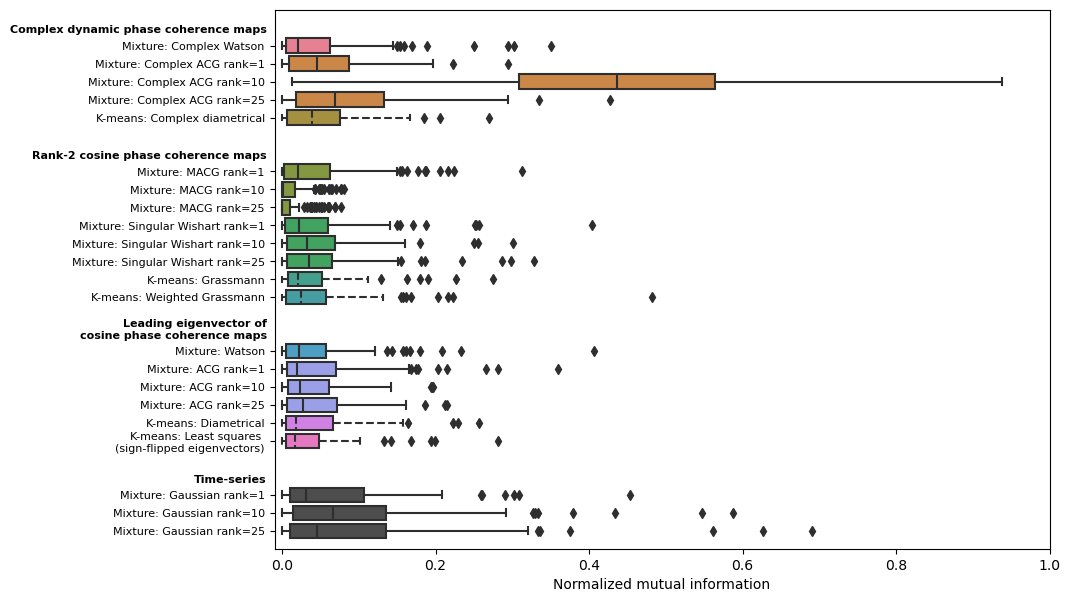

In [201]:
order = ['Mixture: Complex Watson',
         'Mixture: Complex ACG rank=1','Mixture: Complex ACG rank=10','Mixture: Complex ACG rank=25',
         'K-means: Complex diametrical','','',
         'Mixture: MACG rank=1','Mixture: MACG rank=10','Mixture: MACG rank=25',
         'Mixture: Singular Wishart rank=1','Mixture: Singular Wishart rank=10','Mixture: Singular Wishart rank=25',
         'K-means: Grassmann','K-means: Weighted Grassmann','','',
         'Mixture: Watson', 
         'Mixture: ACG rank=1','Mixture: ACG rank=10','Mixture: ACG rank=25',
         'K-means: Diametrical','K-means: Least squares \n(sign-flipped eigenvectors)','','',
         'Mixture: Gaussian rank=1','Mixture: Gaussian rank=10','Mixture: Gaussian rank=25']
styles = ['-']+['-']*3+['--']+['-']*3+['-']*3+['--']*2+['-']+['-']*3+['--']*2+['-']*3
#repeat every element of styles six times
styles2 = [item for item in styles for i in range(5)]
palette_husl = sns.color_palette("husl", n_colors=11, desat=1)
palette_husl.append((0.3,0.3,0.3))
palette_husl2 = [palette_husl[0]]+[palette_husl[1]]*3+[palette_husl[2]]*3+[palette_husl[3]]*3+[palette_husl[4]]*3+[palette_husl[5]]+[palette_husl[6]]*3+[palette_husl[7]]+[palette_husl[8]]*3+[palette_husl[9]]+[palette_husl[10]]*3+[palette_husl[11]]*3
df_fig = df2[df2['Set']=='Out-of-sample test']

fig = plt.figure(figsize=(10,7))
sns.boxplot(x='NMI', y='names2', data=df_fig, palette=palette_husl2, order=order)
plt.xlabel('Normalized mutual information')
plt.ylabel('')
plt.xlim([-0.01,1])
plt.ylim([28,-2])
plt.yticks(np.concatenate([np.arange(5),np.arange(8)+7,np.arange(6)+17,np.arange(3)+25]),fontsize=8)
# add extra text next to y-ticks that aren't there
plt.text(-0.02, -0.7, 'Complex dynamic phase coherence maps', fontsize=8,fontweight='bold', ha='right')
plt.text(-0.02, 6.3, 'Rank-2 cosine phase coherence maps', fontsize=8,fontweight='bold', ha='right')
plt.text(-0.02, 16.3, 'Leading eigenvector of\ncosine phase coherence maps', fontsize=8,fontweight='bold', ha='right')
plt.text(-0.02, 24.3, 'Time-series', fontsize=8,fontweight='bold', ha='right')

# change the line styles
l = 0
for i,artist in enumerate(plt.gca().get_children()):
    if isinstance(artist, plt.Line2D):
        #if linestyle is not none
        if artist.get_linestyle() != 'None':
            artist.set_linestyle(styles2[l])
            l+=1
# print(l)
plt.savefig('figs/motorsocial_noGSR.png', bbox_inches='tight', dpi=300)